# Membership Level Purchase Analysis
## Membership Level vs. Items Purchased and Total Spend

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sqlite3
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

For the Membership Level Purchase Analysis, we will use the following columns and drop the rest:

![Columns used in this analysys](../Images/Membership_Level_Purchase_Analysis.png)

In [22]:
# Connect to the SQLite database
# conn = sqlite3.connect('../sql/Customer_Behavior.db')

# Define your SQL query to only select the three columns used for this analysis
# query = "SELECT TRIM([Membership Type]) as 'Membership Type', [Total Spend], [Items Purchased]FROM E_Comm_Customer_Behavior"

# Use pandas to execute the query and read the data into a DataFrame
# df = pd.read_sql_query(query, conn)

# Define the database path and the query
db_path = '../sql/Customer_Behavior.db'
query = "SELECT TRIM([Membership Type]) as 'Membership Type', [Total Spend], [Items Purchased] FROM E_Comm_Customer_Behavior"

# Use a context manager to ensure the connection is closed properly
with sqlite3.connect(db_path) as conn:
    df = pd.read_sql_query(query, conn)

# Close the database connection
# conn.close()

Let's review, describe, and print the dataset.

In [23]:
print(df.head())


  Membership Type  Total Spend  Items Purchased
0            Gold      1120.20               14
1          Silver       780.50               11
2          Bronze       510.75                9
3            Gold      1480.30               19
4          Silver       720.40               13


In [24]:
print(df.shape)


(350, 3)


In [25]:
print(df.describe())


       Total Spend  Items Purchased
count   350.000000       350.000000
mean    845.381714        12.600000
std     362.058695         4.155984
min     410.800000         7.000000
25%     502.000000         9.000000
50%     775.200000        12.000000
75%    1160.600000        15.000000
max    1520.100000        21.000000


In [26]:
print(df.columns)

Index(['Membership Type', 'Total Spend', 'Items Purchased'], dtype='object')


## Plan
### Data Processing and Cleaning:

- Check for missing values and handle them.
- Ensure data types are appropriate.
- Encode categorical variables if necessary.

### Exploratory Data Analysis (EDA):
- Visualize the distribution of the number of items purchased.
- Compare the number of items purchased across different membership types.
- Investigate other relationships and trends in the data.

### Statistical Analysis and Modeling:
- Perform statistical tests to determine if there are significant differences in the number of items purchased across membership types.
- Develop and evaluate regression models to predict the number of items purchased based on membership type and other factors.

In [27]:
# Data Processing and Cleaning

# Check for missing values
missing_values = df.isnull().sum()

# Display missing values
print("Missing values per column:\n", missing_values)

# Display dataframe info
print("\nDataframe Info:")
df.info()


Missing values per column:
 Membership Type    0
Total Spend        0
Items Purchased    0
dtype: int64

Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Membership Type  350 non-null    object 
 1   Total Spend      350 non-null    float64
 2   Items Purchased  350 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 8.3+ KB


There are **NO** missing values are in the three columns chosen for this dataset.

Now, we'll visualize and compare the number of items purchased across different membership types as part of our Exploratory Data Analysis (EDA).

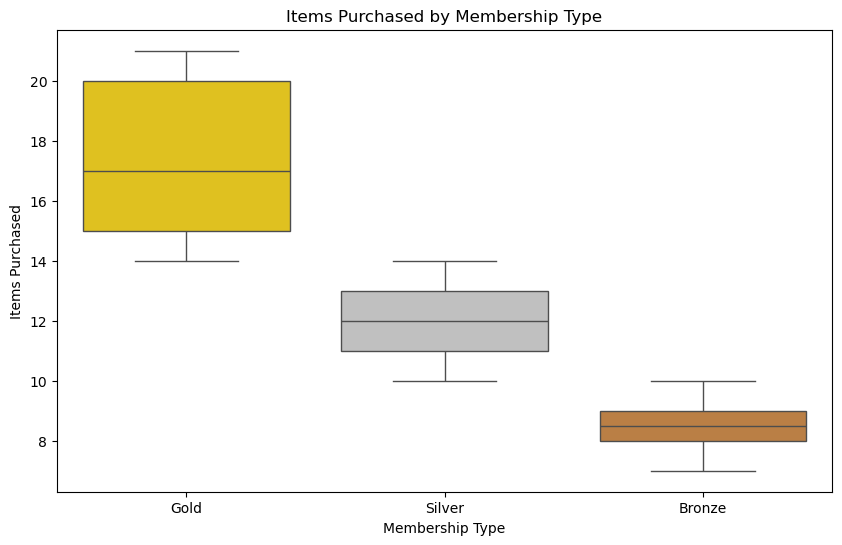

In [28]:
# Define custom colors for membership types
custom_palette = {
    'Gold': '#FFD700',    # Gold
    'Silver': '#C0C0C0',  # Silver
    'Bronze': '#CD7F32'   # Bronze
}

# Visualize the distribution of 'Items Purchased' across 'Membership Type'
plt.figure(figsize=(10, 6))
sns.boxplot(x='Membership Type', y='Items Purchased', data=df, hue='Membership Type', palette=custom_palette)
plt.title('Items Purchased by Membership Type')
plt.xlabel('Membership Type')
plt.ylabel('Items Purchased')
plt.show()


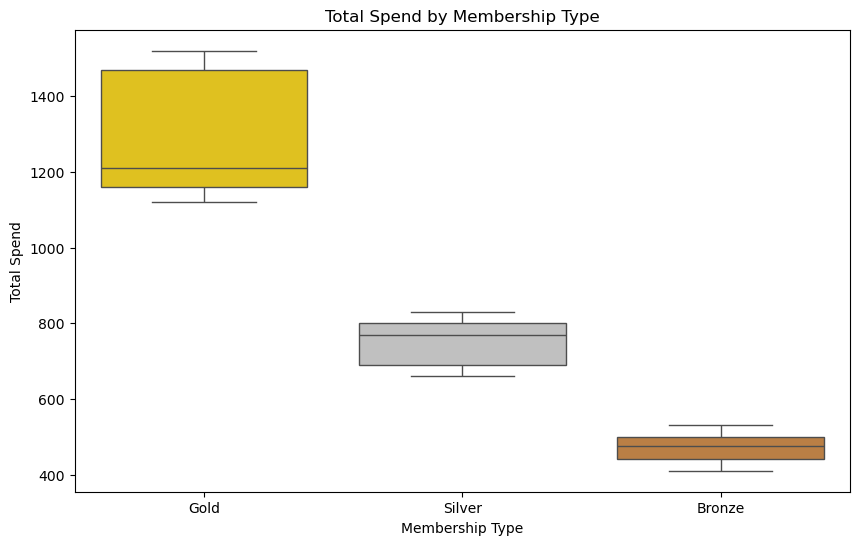

In [29]:
# Define custom colors for membership types
custom_palette = {
    'Gold': '#FFD700',    # Gold
    'Silver': '#C0C0C0',  # Silver
    'Bronze': '#CD7F32'   # Bronze
}

# Visualize the distribution of 'Total Spend' across 'Membership Type'
plt.figure(figsize=(10, 6))
sns.boxplot(x='Membership Type', y='Total Spend', data=df, hue='Membership Type', palette=custom_palette)
plt.title('Total Spend by Membership Type')
plt.xlabel('Membership Type')
plt.ylabel('Total Spend')
plt.show()


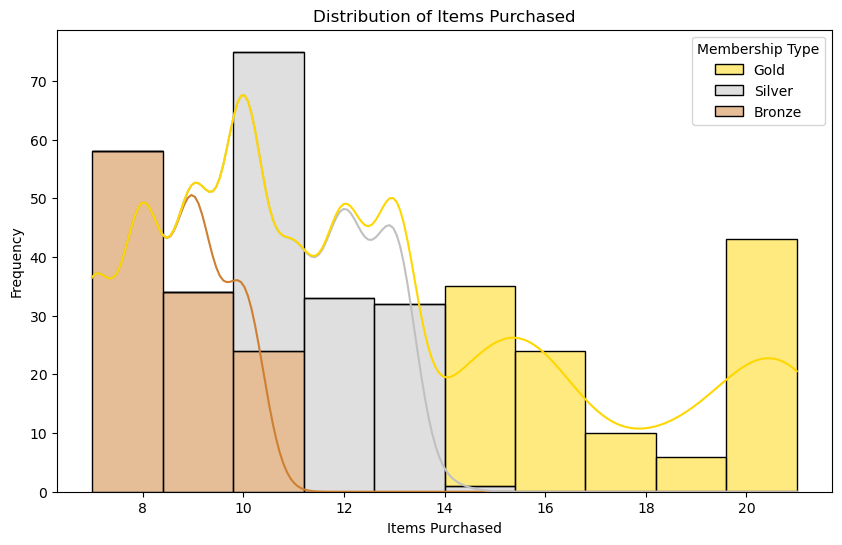

In [30]:
# Visualize the distribution of 'Items Purchased' using histograms
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Items Purchased', hue='Membership Type', multiple='stack', kde=True, palette=custom_palette)
plt.title('Distribution of Items Purchased')
plt.xlabel('Items Purchased')
plt.ylabel('Frequency')
plt.show()

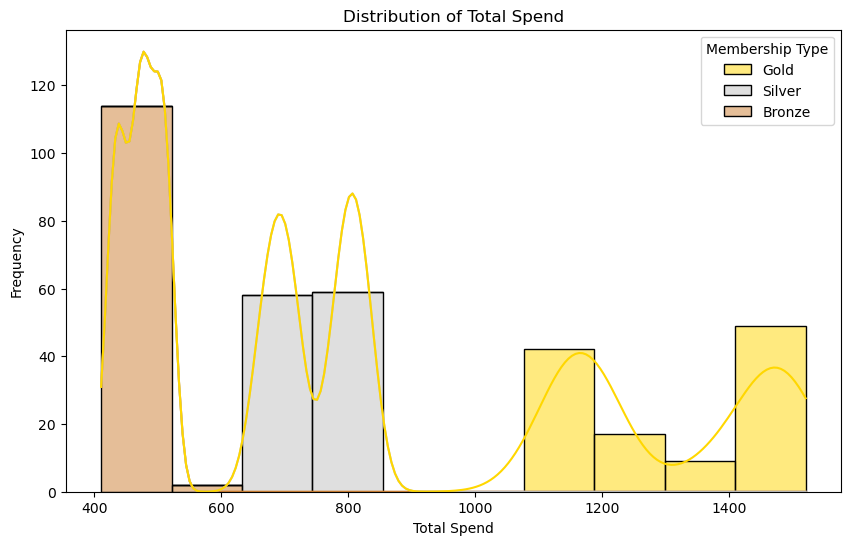

In [31]:
# Visualize the distribution of 'Total Spend' using histograms
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Total Spend', hue='Membership Type', multiple='stack', kde=True, palette=custom_palette)
plt.title('Distribution of Total Spend')
plt.xlabel('Total Spend')
plt.ylabel('Frequency')
plt.show()

The boxplot and histogram, reveal the purchasing patterns of different types of members which provides a critical insight for our team.

**Findings:**

- Gold members buy the most and spend the most.
- Silver members buy moderately and spend moderately, while Bronze members buy and spend the least.
- These insights suggest that efforts should focus on keeping Gold members happy and finding ways to encourage Silver and Bronze members to spend more.


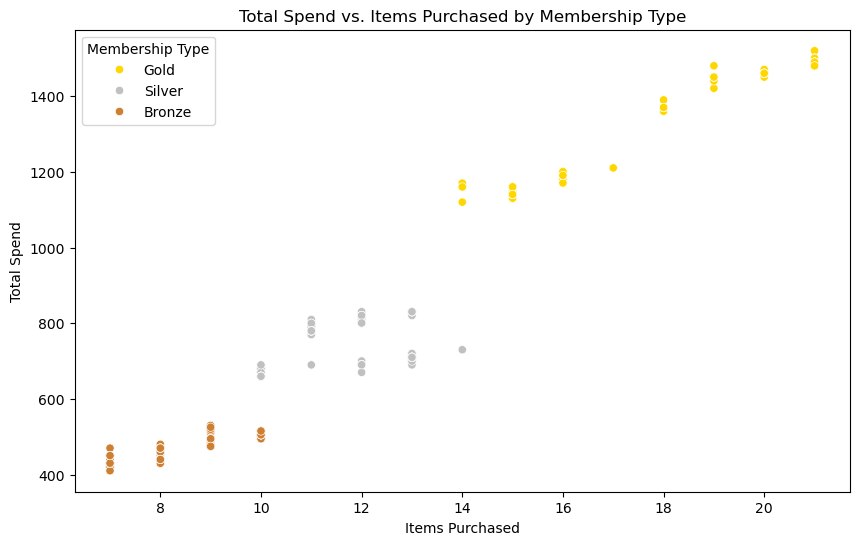

In [32]:
# Scatter plot of 'Total Spend' vs. 'Items Purchased' colored by 'Membership Type'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Items Purchased', y='Total Spend', hue='Membership Type', data=df, palette=custom_palette)
plt.title('Total Spend vs. Items Purchased by Membership Type')
plt.xlabel('Items Purchased')
plt.ylabel('Total Spend')
plt.legend(title='Membership Type')
plt.show()


This scatter plot shows how different `membership levels` correlate with `total spent` and `items purchased`, providing valuable insights for business strategies and marketing efforts.

- More purchases usually mean higher overall spending. This applies to all types of memberships.
- The type of membership significantly affects spending habits. Gold members spend the most, followed by Silver and Bronze members.











**Next Steps:**

- **Statistical Analysis:** We'll conduct statistical tests to see if the differences we noticed are essential.
- **Regression Analysis:** We'll create a regression model to measure how membership type affects the number of items purchased.

Let's start with the statistical analysis using Analysis of Variance (ANOVA) for Items Purchased:

In [33]:
# Perform Analysis of Variance (ANOVA) to see if there are significant differences in items purchased across membership types
anova_result = stats.f_oneway(
    df[df['Membership Type'] == 'Gold']['Items Purchased'],
    df[df['Membership Type'] == 'Silver']['Items Purchased'],
    df[df['Membership Type'] == 'Bronze']['Items Purchased']
)

anova_result

F_onewayResult(statistic=848.835618197024, pvalue=2.2593774292859393e-134)

In [34]:
# Perform Analysis of Variance (ANOVA) to see if there are significant differences in total spend across membership types
anova_result = stats.f_oneway(
    df[df['Membership Type'] == 'Gold']['Total Spend'],
    df[df['Membership Type'] == 'Silver']['Total Spend'],
    df[df['Membership Type'] == 'Bronze']['Total Spend']
)

anova_result

F_onewayResult(statistic=2294.4940630746064, pvalue=8.846193459674085e-201)

- There is a statistically significant difference in the 'total spend' among the different 'membership types'.
- Like the 'items purchased', the 'membership type' influences the variation in 'total spend' and is not due to random chance.
- The number of items purchased and the total spend significantly differ across membership types.
- These findings remind us of the role that membership types play in predicting customer purchasing behaviour and spending patterns. They highlight the urgency of tailoring our strategies to these types for maximum impact. For the business, tailoring marketing strategies and offers based on membership types can effectively optimize customer engagement and revenue.


**Regression Analysis**
- We will create regression models to measure how `membership type` affect both the number of `items purchased` and `total spend`.
- We will use a linear regression model and represent membership type with dummy variables.

Regression model to measure how `membership type` affect `items purchased`

In [35]:
# Encode 'Membership Type' using one-hot encoding
encoder = OneHotEncoder(drop=None)
membership_encoded = encoder.fit_transform(df[['Membership Type']])

# Convert to DataFrame and concatenate with the original data
membership_encoded_df = pd.DataFrame(membership_encoded.toarray(), columns=encoder.get_feature_names_out(['Membership Type']))
df_encoded = pd.concat([df, membership_encoded_df], axis=1)
df_encoded = df_encoded.dropna(subset=['Membership Type_Gold','Membership Type_Silver','Membership Type_Bronze', 'Items Purchased'])

# Prepare the features and target variable
X = df_encoded[['Membership Type_Gold','Membership Type_Silver','Membership Type_Bronze']]
y = df_encoded['Items Purchased']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Evaluate the model
r_squared = model.score(X_test, y_test)
coefficients = model.coef_
intercept = model.intercept_

# Print the results
print(f'R-squared: {r_squared}')
print(f'Coefficients: {coefficients}')
print(f'Intercept: {intercept}')

R-squared: 0.8279248589293938
Coefficients: [1.01758528e+14 1.01758528e+14 1.01758528e+14]
Intercept: -101758527906336.66


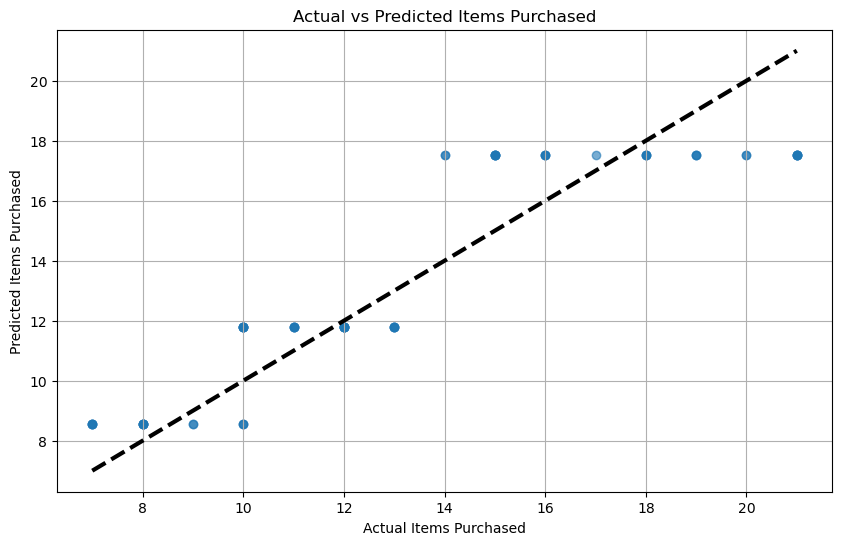

In [36]:
# Plot the predictions against the actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual Items Purchased')
plt.ylabel('Predicted Items Purchased')
plt.title('Actual vs Predicted Items Purchased')
plt.grid(True)
plt.show()

### Original Regression Model (Membership Type Affecting Items Purchased)

An R-squared value of 0.828 means that approximately 82.8% of the variability in the number of items purchased can be explained by the membership type alone.

While the model explains a significant portion of the variability in items purchased, the extreme values of the coefficients and intercept suggest that the model may not be practical for interpretation.

We are now:
- Including the **Total Spend** column in the regression model to determine if we can improve its predictions, and
- Re-training the regression model to evaluate its performance.

In [37]:
# Prepare the features and target variable, including 'Total Spend'
X = df_encoded[['Membership Type_Gold', 'Membership Type_Silver', 'Membership Type_Bronze', 'Total Spend']]
y = df_encoded['Items Purchased']

# Ensure there are no NaN values in the features and target variable
df_encoded = df_encoded.dropna(subset=['Membership Type_Gold','Membership Type_Silver','Membership Type_Bronze', 'Total Spend', 'Items Purchased'])

# Split the data into training and testing sets
# We have increased the test_size from 0.2 to 0.3 to improve the accuracy and reliability of the model evaluation.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Evaluate the model
r_squared = model.score(X_test, y_test)
coefficients = model.coef_
intercept = model.intercept_

# Print the results
print(f'R-squared: {r_squared}')
print(f'Coefficients: {coefficients}')
print(f'Intercept: {intercept}')

R-squared: 0.9610806562426754
Coefficients: [-2.19003035  0.59982913  1.59020121  0.01537935]
Intercept: -0.33086384318019135


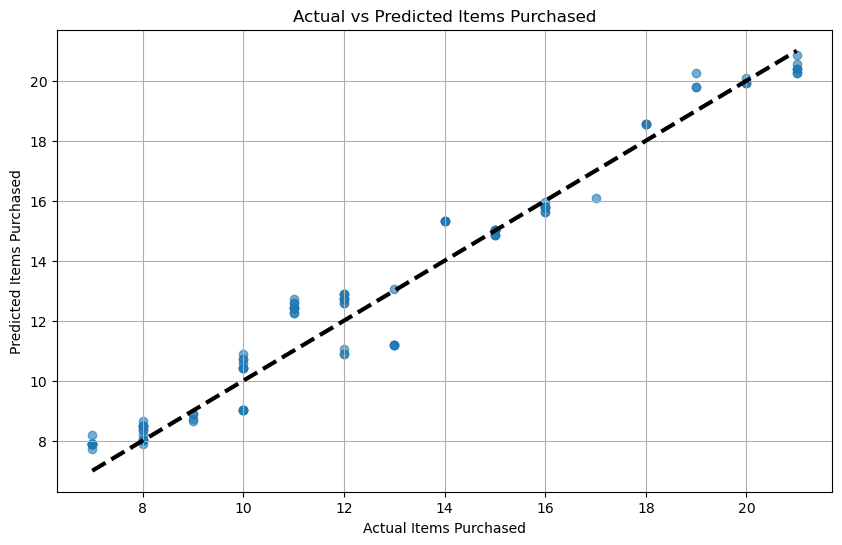

In [38]:
# Plot the predictions against the actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual Items Purchased')
plt.ylabel('Predicted Items Purchased')
plt.title('Actual vs Predicted Items Purchased')
plt.grid(True)
plt.show()

### Improved Regression Model (Including Total Spend):
An R-squared value of 0.961 means that approximately 96.1% of the variability in the number of items purchased can be explained by the membership type and total spend together.

The intercept value is more reasonable than the Original Regression Model (Membership Type affecting Items Purchased).

Adding total spend to the regression model significantly improves its ability to predict and explain a larger portion of the variation in items purchased. This model offers a more practical interpretation of how membership type and total spending affect the number of items purchased.

### CONCLUSIONS
- The data shows that customers with a Gold membership tend to buy more items than those with Silver or Bronze memberships.
- The analysis indicates that the membership type significantly impacts the number of items purchased, with Gold members buying more on average.
- Including the total spend in the analysis further enhances the model's accuracy, highlighting the importance of membership type and total spend in predicting the number of items purchased.

###  Recommendations Based on Membership Spending Patterns
- Focus marketing strategies on retaining Gold members and encouraging more purchases through exclusive offers or rewards.
- Encourage Bronze and Silver members to spend more and purchase more often by offering targeted promotions or upgrading membership benefits.
- Use spending patterns to create customized and effective promotions tailored to each type of membership's purchasing habits.